<p align="center">
<img src='../../img/VerticaMLPython.png' width="180px">
</p>

# Vertica ML Python Exercise 2

During this exercice, we will see:
<ul>
    <li> How to detect outliers using 4 different techniques (DBSCAN, KMeans, LOF and Normal Distribution)
    <li> How to fill outliers
    <li> How to drop outliers
    <li> Find the KMeans K
    <li> How to realize different scatter plots
</ul>
## Initialization

Let's create a cursor using the vertica_cursor function

In [1]:
from vertica_ml_python.utilities import vertica_cursor
cur = vertica_cursor("VerticaDSN")

During this study, we will work with the heart disease dataset. You'll need to read the 'heart.csv' file.

In [2]:
from vertica_ml_python.utilities import read_csv
from vertica_ml_python.utilities import drop_table
drop_table('heart', cur)
heart = read_csv('heart.csv', cur)
print(heart)

The table heart was successfully dropped.
The table public.heart has been successfully created.


,age,thalach,trestbps,fbs,slope,ca,num,sex,cp,exang,restecg,chol,oldpeak,thal
0,70.00,109.00,130.00,0.00,2.00,3.00,2,1.00,4.00,0.00,2.00,322.00,2.40,3.00
1,67.00,160.00,115.00,0.00,2.00,0.00,1,0.00,3.00,0.00,2.00,564.00,1.60,7.00
2,57.00,141.00,124.00,0.00,1.00,0.00,2,1.00,2.00,0.00,0.00,261.00,0.30,7.00
3,64.00,105.00,128.00,0.00,2.00,1.00,1,1.00,4.00,1.00,0.00,263.00,0.20,7.00
4,74.00,121.00,120.00,0.00,1.00,1.00,1,0.00,2.00,1.00,2.00,269.00,0.20,3.00
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: heart, Number of rows: 270, Number of columns: 14


This dataset contains many information of 270 patients including:
<ul>
    <li><b>age:</b> age in years</li>
    <li><b>thalach:</b> maximum heart rate achieved</li>
    <li><b>trestbps:</b> resting blood pressure (in mm Hg on admission to the hospital) </li>
    <li><b>fbs:</b> (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) </li>
    <li><b>slope:</b> the slope of the peak exercise ST segment (Value 1: upsloping; Value 2: flat; Value 3: downsloping) </li>
    <li><b>ca:</b> number of major vessels (0-3) colored by flourosopy </li>
    <li><b>num:</b> diagnosis of heart disease (angiographic disease status) (Value 1: < 50% diameter narrowing; Value 2: > 50% diameter narrowing)</li>
    <li><b>sex:</b> sex (1 = male; 0 = female) </li>
    <li><b>cp:</b> hest pain type (Value 1: typical angina; Value 2: atypical angina; Value 3: non-anginal pain; Value 4: asymptomatic) </li>
    <li><b>exang:</b> exercise induced angina (1 = yes; 0 = no) </li>
    <li><b>restecg:</b> resting electrocardiographic results (Value 0: normal; Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV); Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria) </li>
    <li><b>chol:</b> serum cholestoral in mg/dl </li>
    <li><b>oldpeak:</b> ST depression induced by exercise relative to rest </li>
    <li><b>thal:</b> 3 = normal; 6 = fixed defect; 7 = reversable defect </li>
</ul>

The purpose is to find people having heart complications compare to the rest. 

## Outliers Detection

Let's explore the data by displaying descriptive statistics of all the columns.

In [3]:
heart.describe()

,count,mean,std,min,25%,50%,75%,max,unique
age,270,54.4333333333334,9.10906652389821,29.0,48.0,55.0,61.0,77.0,41
ca,270,0.67037037037037,0.943896383488116,0.0,0.0,0.0,1.0,3.0,4
chol,270,249.659259259259,51.6862371164312,126.0,213.0,245.0,280.0,564.0,144
cp,270,3.17407407407407,0.950090033922864,1.0,3.0,3.0,4.0,4.0,4
exang,270,0.32962962962963,0.470951591301383,0.0,0.0,0.0,1.0,1.0,2
fbs,270,0.148148148148148,0.355906476970731,0.0,0.0,0.0,0.0,1.0,2
num,270,1.44444444444444,0.497826751588616,1.0,1.0,1.0,2.0,2.0,2
oldpeak,270,1.05,1.145209839378,0.0,0.0,0.8,1.6,6.2,39
restecg,270,1.02222222222222,0.99789120896611,0.0,0.0,2.0,2.0,2.0,3
sex,270,0.677777777777778,0.46819540715527,0.0,0.0,1.0,1.0,1.0,2


<object>

We will only work with the maximum heart rate achieved (thalach) and the serum cholestoral (chol). We will be able to identify outliers with different techniques and visualize the results.

<b>Question 1: </b>Draw the Scatter Plot of the two variables. What do you notice ?

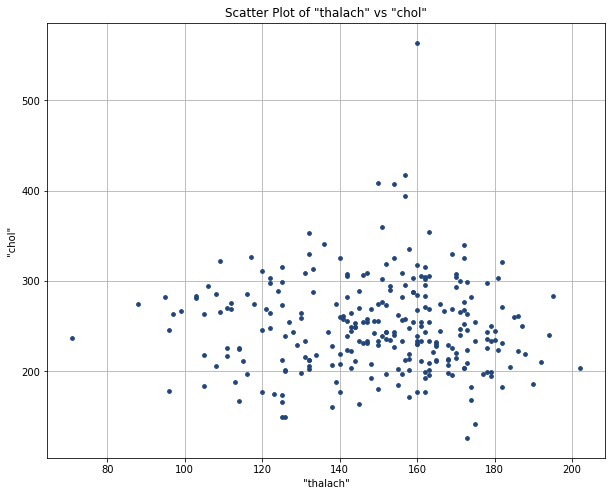

In [4]:
%matplotlib inline
x = heart.scatter(["thalach", "chol"])

<p style="color:red">We can see some outliers of the distributions. People having a high cholesterol and others having a very low heart rate.</p>

<b>Question 2: </b>Add the Global Outliers of the distribution using the 'outliers' method. Draw again the Scatter Plot with this time marking the outliers. Find visually the number of outliers and explain the result. 

The new vColumn "global_outliers" was added to the vDataframe.


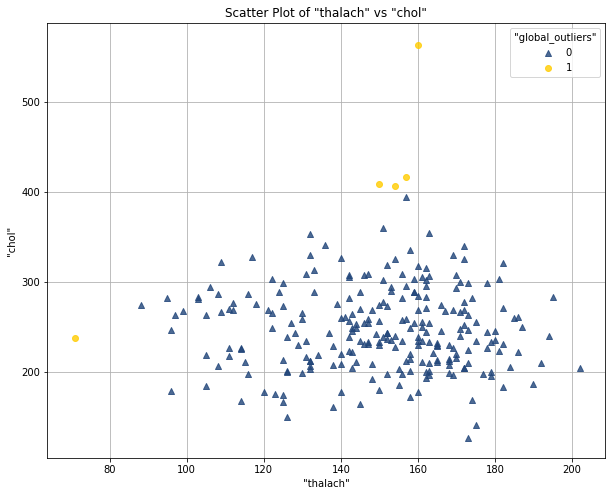

In [5]:
heart.outliers(["thalach", "chol"], "global_outliers")
x = heart.scatter(["thalach", "chol"], catcol = "global_outliers")

<p style="color:red">We detected the 4 global outliers of the distribution. They are well defined in the last answer.</p>

You can drop or fill these outliers by using respectively the 'drop_outliers' and 'fill_outliers' methods. It will only consider global outliers of the distribution. Otherwise you can use the 'filter' method to do it.

In [6]:
heart["chol"].fill_outliers(threshold = 3.0)
heart["thalach"].drop_outliers(threshold = 3.0)

1 element was filtered


,age,thalach,trestbps,fbs,slope,ca,num,sex,cp,exang,restecg,chol,oldpeak,thal,global_outliers
0,29.00,202.00,130.00,0.00,1.00,0.00,1,1.00,2.00,0.00,2.00,204.00000000000000,0.00,3.00,0
1,34.00,192.00,118.00,0.00,1.00,0.00,1,0.00,2.00,0.00,0.00,210.00000000000000,0.70,3.00,0
2,34.00,174.00,118.00,0.00,1.00,0.00,1,1.00,1.00,0.00,2.00,182.00000000000000,0.00,3.00,0
3,35.00,182.00,138.00,0.00,1.00,0.00,1,0.00,4.00,0.00,0.00,183.00000000000000,1.40,3.00,0
4,35.00,130.00,120.00,0.00,2.00,0.00,2,1.00,4.00,1.00,0.00,198.00000000000000,1.60,7.00,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: heart, Number of rows: 269, Number of columns: 15

<b>Question 3: </b>Use the DBSCAN with epsilon = 20 and min_samples = 10. The outliers will be labeled with the class -1. What do you notice ?

The table dbscan_heart was successfully dropped.


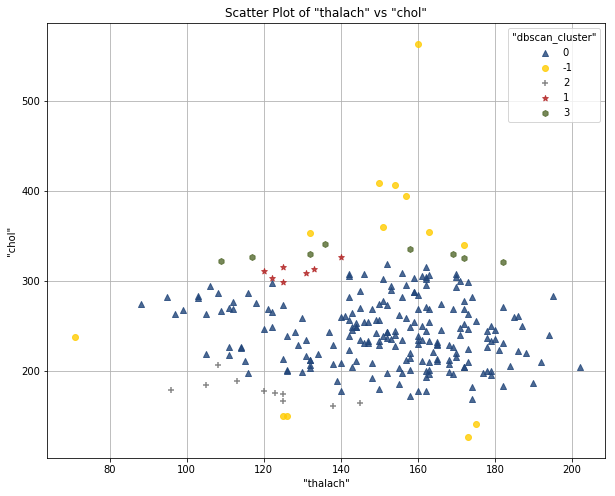

In [7]:
from vertica_ml_python.learn.cluster import DBSCAN

drop_table("dbscan_heart", cur)
model = DBSCAN("dbscan_heart", cur, eps = 20, min_samples = 10)
model.fit("heart", ["thalach", "chol"])
model.plot()

<p style="color:red">DBSCAN will detect the isolated point and classify them as outliers. It will also group some similar people together. DBSCAN is not determinist and it can change at each computation.</p>

<b>Question 4: </b>Now, use the Local Outlier Factor Algorithm and draw the LOF graph. Build a Virtual Dataframe using the created table and create a new label based on the LOF (>1.5 = outliers)

The table lof_heart was successfully dropped.


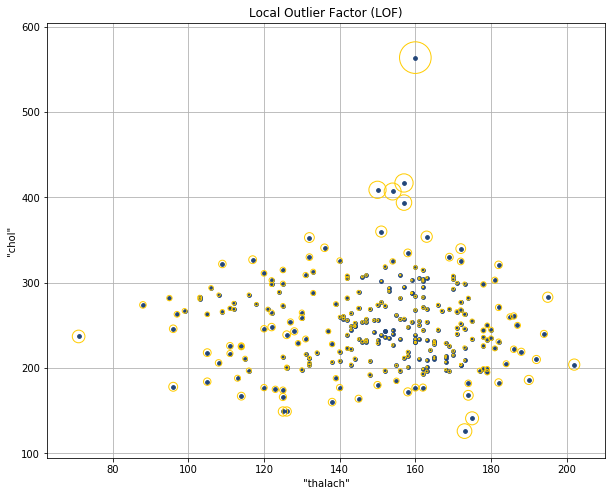

The new vColumn "outliers" was added to the vDataframe.


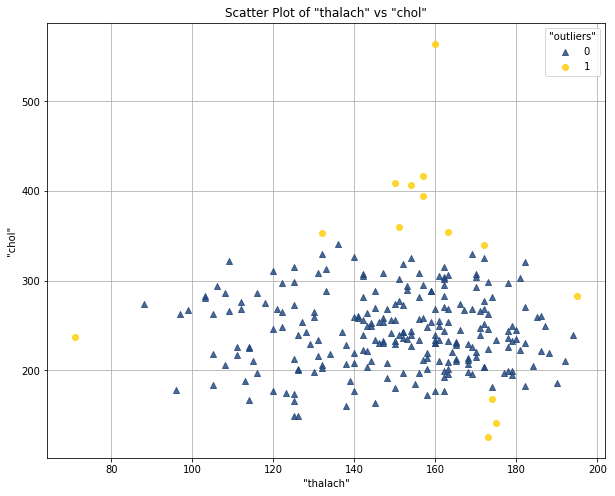

In [8]:
from vertica_ml_python.learn.neighbors import LocalOutlierFactor

drop_table("lof_heart", cur)
model = LocalOutlierFactor("lof_heart", cur)
model.fit("heart", ["thalach", "chol"])
model.plot()

from vertica_ml_python import vDataframe

lof_heart = vDataframe("lof_heart", cursor = cur)
lof_heart.eval("outliers", "(CASE WHEN lof_score > 1.5 THEN 1 ELSE 0 END)")
x = lof_heart.scatter(["thalach", "chol"], catcol = "outliers")

<p style="color:red">The Local Outlier Factor can help to detect isolated point. It generates a score (the LOF). If this score is greater than a threshold (usually between 1.5 and 3), the point is labeled as an outlier. It is working perfectly for this use-case.</p>

<b>Question 5: </b>The last technique to find outliers is using the KMeans algorithm. However, we never know the number of clusters in advance. Use the elbow curve to find it. Create a KMeans model with this number. Draw the model prediction and identify the outliers.

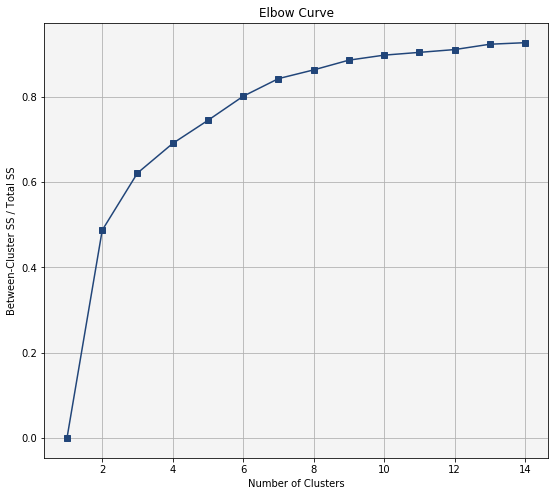

In [9]:
from vertica_ml_python.learn.plot import elbow

x = elbow(["thalach", "chol"], "heart", cur)

The model kmeans_heart was successfully dropped.


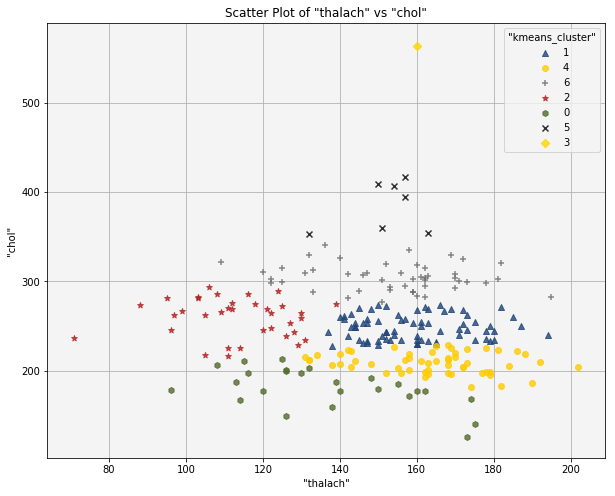

In [10]:
from vertica_ml_python.learn.cluster import KMeans
from vertica_ml_python.utilities import drop_model

drop_model("kmeans_heart", cur)
model = KMeans("kmeans_heart", cur, n_cluster = 7)
model.fit("heart", ["thalach", "chol"])
model.plot()

<p style="color:red">KMeans will compute different clusters. Clusters with a small number of elements will be seen as an anomalious cluster. In this use-case, we can identify one very suspicious cluster with one element: the person having a very high chol.</p>

<b>Question 6: </b>Use your favourite technique to identify the outliers and draw histograms to see what part of the population is affected by huge complications.

The table lof_heart was successfully dropped.
The new vColumn "outliers" was added to the vDataframe.


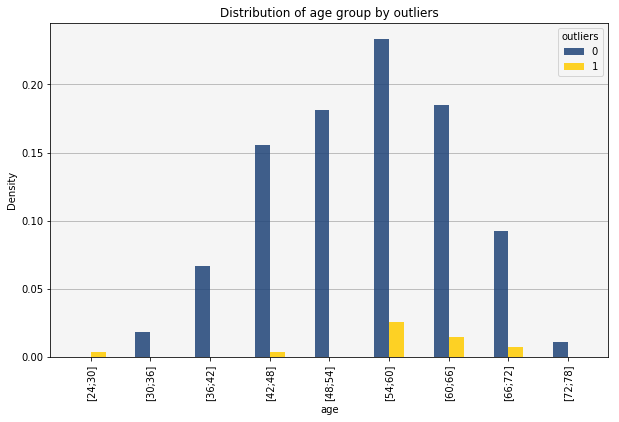

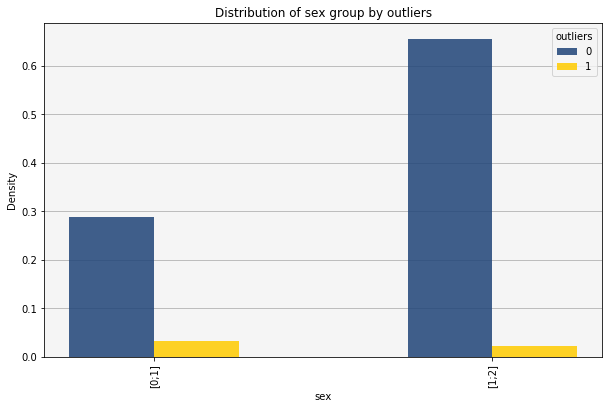

In [11]:
from vertica_ml_python.learn.neighbors import LocalOutlierFactor

drop_table("lof_heart", cur)
model = LocalOutlierFactor("lof_heart", cur)
model.fit("heart", ["thalach", "chol"], key_columns = ["age", "sex"])

from vertica_ml_python import vDataframe

lof_heart = vDataframe("lof_heart", cursor = cur)
lof_heart.eval("outliers", "(CASE WHEN lof_score > 1.5 THEN 1 ELSE 0 END)")
x = lof_heart.hist(["age", "outliers"])
x = lof_heart.hist(["sex", "outliers"])